In [2]:
import os
import subprocess

java_home = subprocess.check_output(["/usr/libexec/java_home", "-v", "17"]).strip().decode('utf-8')

# Set JAVA_HOME and PATH
os.environ["JAVA_HOME"] = java_home
os.environ["PATH"] = os.path.join(java_home, "bin") + ":" + os.environ["PATH"]
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local pyspark-shell"

# Verify JAVA_HOME and Java version
print("JAVA_HOME:", os.environ['JAVA_HOME'])
!java -version

JAVA_HOME: /Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home
java version "17.0.8" 2023-07-18 LTS
Java(TM) SE Runtime Environment (build 17.0.8+9-LTS-211)
Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MLP") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "4") \
    .getOrCreate()

24/11/27 12:41:36 WARN Utils: Your hostname, ChandeMacBook-Air-8.local resolves to a loopback address: 127.0.0.1; using 10.89.238.200 instead (on interface en0)
24/11/27 12:41:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/27 12:41:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
file_path = "output/processedv2.parquet"
df = spark.read.parquet(file_path)

+-------+--------+--------+-------+------+--------+--------+--------+--------+-------+--------+--------+--------+-----+--------+--------+--------+--------+--------+---+
|GENHLTH|_AGEG5YR|_RFHYPE6|EMPLOY1|_MICHD|_DRDXAR2|_HCVU653|_RFCHOL3|METVL12_|ALCDAY4|_BMI5CAT|DIFFWALK|_TOTINDA|EDUCA|_INCOMG1|CHCKDNY2|FALL12MN|SMOKE100|CVDINFR4|  y|
+-------+--------+--------+-------+------+--------+--------+--------+--------+-------+--------+--------+--------+-----+--------+--------+--------+--------+--------+---+
|    4.0|    11.0|     2.0|    1.0|   2.0|     1.0|     9.0|     1.0|   103.0|  888.0|     2.0|     1.0|     1.0|  5.0|     4.0|     2.0|    88.0|     1.0|     2.0|  0|
|    2.0|     9.0|     1.0|    2.0|   2.0|     2.0|     1.0|     2.0|   106.0|  220.0|     2.0|     2.0|     1.0|  6.0|     5.0|     2.0|     2.0|     2.0|     2.0|  0|
|    3.0|     8.0|     1.0|    1.0|   2.0|     2.0|     1.0|     1.0|   104.0|  210.0|     4.0|     2.0|     1.0|  6.0|     5.0|     2.0|    88.0|     2.0|

In [52]:
df.show(5)
df.printSchema()

+-------+--------+--------+-------+------+--------+--------+--------+--------+-------+--------+--------+--------+-----+--------+--------+--------+--------+--------+---+
|GENHLTH|_AGEG5YR|_RFHYPE6|EMPLOY1|_MICHD|_DRDXAR2|_HCVU653|_RFCHOL3|METVL12_|ALCDAY4|_BMI5CAT|DIFFWALK|_TOTINDA|EDUCA|_INCOMG1|CHCKDNY2|FALL12MN|SMOKE100|CVDINFR4|  y|
+-------+--------+--------+-------+------+--------+--------+--------+--------+-------+--------+--------+--------+-----+--------+--------+--------+--------+--------+---+
|    4.0|    11.0|     2.0|    1.0|   2.0|     1.0|     9.0|     1.0|   103.0|  888.0|     2.0|     1.0|     1.0|  5.0|     4.0|     2.0|    88.0|     1.0|     2.0|  0|
|    2.0|     9.0|     1.0|    2.0|   2.0|     2.0|     1.0|     2.0|   106.0|  220.0|     2.0|     2.0|     1.0|  6.0|     5.0|     2.0|     2.0|     2.0|     2.0|  0|
|    3.0|     8.0|     1.0|    1.0|   2.0|     2.0|     1.0|     1.0|   104.0|  210.0|     4.0|     2.0|     1.0|  6.0|     5.0|     2.0|    88.0|     2.0|

In [10]:
num_columns = len(df.columns)
num_rows = df.count()
# Print the dimensions
print(f"Dimensions of DataFrame: {num_rows} rows, {num_columns} columns")

Dimensions of DataFrame: 251504 rows, 20 columns


In [82]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Replace feature_cols with your actual feature column names
feature_cols = df.columns
feature_cols.remove("y")

# Create vector assembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(df)

# Split the data into training and test sets (80:20)
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=42)

In [83]:
# Show the counts of each split
print(f"Training set count: {train_df.count()}")
print(f"Test set count: {test_df.count()}")

Training set count: 201024


Test set count: 50480


In [89]:
# Define the neural network architecture
# [input layer size, hidden layer size, output layer size]
layers = [len(feature_cols), 12, 6, 2] 

# Create the MultilayerPerceptronClassifier
mlp = MultilayerPerceptronClassifier(
    layers=layers,
    labelCol="y",
    featuresCol="features",
    maxIter=50,
    blockSize=64,
    seed=1
)

# Create parameter grid for Cross Validation
paramGrid = ParamGridBuilder() \
    .addGrid(mlp.maxIter, [25, 50]) \
    .addGrid(mlp.blockSize, [64, 128]) \
    .build()

# Create evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="y",
    predictionCol="prediction",
    metricName="accuracy"
)

# Create CrossValidator
crossval = CrossValidator(
    estimator=mlp,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

In [90]:
# Fit the model using CrossValidator
cv_model = crossval.fit(train_df)

# Make predictions on test data
predictions = cv_model.transform(test_df)

In [91]:
# Evaluate the model
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy}")

# Show sample predictions
predictions.select("y", "probability", "prediction", "features").show(5)


Test Accuracy = 0.8157091917591125
+---+--------------------+----------+--------------------+
|  y|         probability|prediction|            features|
+---+--------------------+----------+--------------------+
|  0|[0.70380104384153...|       0.0|[1.0,6.0,1.0,1.0,...|
|  0|[0.81082134845583...|       0.0|[1.0,6.0,1.0,1.0,...|
|  0|[0.91198861508663...|       0.0|[1.0,6.0,1.0,1.0,...|
|  0|[0.70352919309418...|       0.0|[1.0,6.0,1.0,1.0,...|
|  0|[0.85992098927829...|       0.0|[1.0,6.0,1.0,1.0,...|
+---+--------------------+----------+--------------------+
only showing top 5 rows



In [97]:
# Calculate the confusion matrix
true_negative = predictions.filter("y=0").filter("prediction=0").count()
print(f"True Negative count: {true_negative}")
false_positive = predictions.filter("y=0").filter("prediction=1").count()
print(f"False Positive count: {false_positive}")
false_negative = predictions.filter("y=1").filter("prediction=0").count()
print(f"False Negative count: {false_negative}")
true_positive = predictions.filter("y=1").filter("prediction=1").count()
print(f"True Positive count: {true_positive}")

True Negative count: 41177


False Positive count: 0


False Negative count: 9303


True Positive count: 0


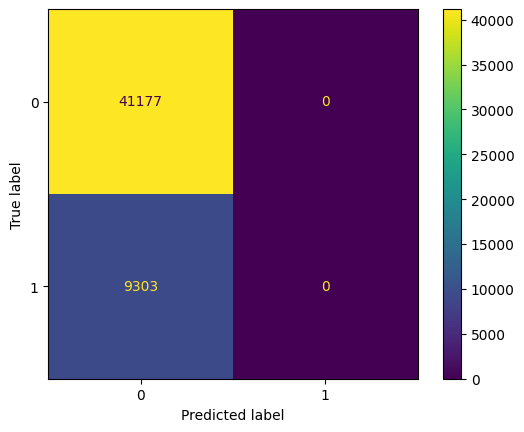

24/11/27 20:55:59 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 216023 ms exceeds timeout 120000 ms
24/11/27 20:55:59 WARN SparkContext: Killing executors is not supported by current scheduler.
24/11/27 21:11:11 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [98]:
#Plot the confusion matrix
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

actual = np.array(test_df.select("y").collect())
predicted = predictions.withColumn("prediction", predictions["prediction"].cast(IntegerType()))
predicted = np.array(predicted.select("prediction").collect())

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()